# Notes on Chapter 9 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

In [1]:
import time

from matplotlib import pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.datasets import load_digits, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, accuracy_score, normalized_mutual_info_score
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

First we create some synthetic data with clusters similar to those shown in the book:

In [2]:
rng = np.random.default_rng(seed=42)

X_clusters = [
    (200, (-2.8, 2.8), 0.1),
    (200, (-2.8, 1.8), 0.1),
    (200, (-2.8, 1.3), 0.1),
    (200, (-1.5, 2.3), 0.3),
    (200, (0.2, 2.3), 0.4),
    ]

X = np.vstack([
    rng.normal(center, scale=scale, size=(count, len(center)))
    for count, center, scale in X_clusters
])
y = np.hstack([
    np.ones(dtype=int, shape=count) * i 
    for i, (count, center, scale) in enumerate(X_clusters)
])

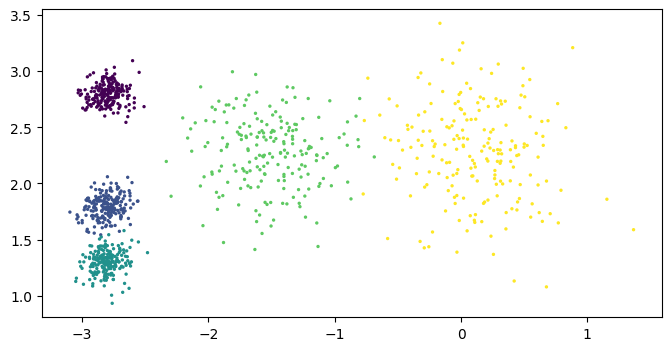

In [3]:
plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], s=2, c=y);

Next we try using K-means to cluster the data.

In [4]:
m = KMeans(n_clusters=5, random_state=42, n_init='auto')
y_hat = m.fit_predict(X)

In [5]:
def KMeansPlot(m, X, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8,4))
        ax=fig.add_subplot()

    y_hat = m.predict(X)
    ax.scatter(X[:,0], X[:,1], s=2, c=y_hat)
    if len(m.cluster_centers_) > 2:
        voronoi_plot_2d(Voronoi(m.cluster_centers_), show_points=False, show_vertices=False, ax=ax);
    ax.set_xlim((min(X[:,0]), max(X[:,0])))
    ax.set_ylim((min(X[:,1]), max(X[:,1])))
    ax.scatter(m.cluster_centers_[:,0], m.cluster_centers_[:,1], marker='x', color='black')

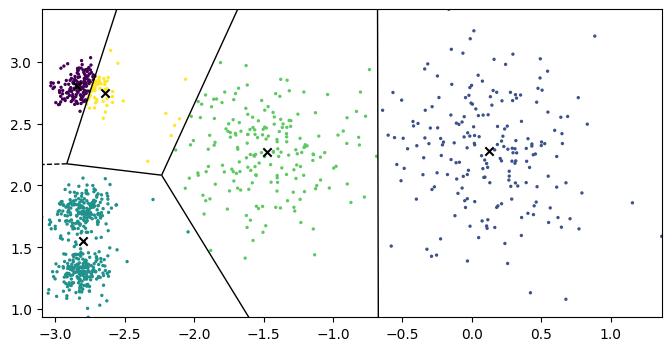

In [6]:
KMeansPlot(m, X)

For large datasets fitting the standard way may take some time

In [7]:
rng = np.random.default_rng(seed=42)
samples_per_cluster = 100000

X_large_clusters = [
    (samples_per_cluster, (-2.8, 2.8), 0.1),
    (samples_per_cluster, (-2.8, 1.8), 0.1),
    (samples_per_cluster, (-2.8, 1.3), 0.1),
    (samples_per_cluster, (-1.5, 2.3), 0.3),
    (samples_per_cluster, (0.2, 2.3), 0.4),
    ]

X_large = np.vstack([
    rng.normal(center, scale=scale, size=(count, len(center)))
    for count, center, scale in X_large_clusters
])
rng.shuffle(X_large)

In [8]:
fit_start_time = time.monotonic()
m = KMeans(n_clusters=5, random_state=42, n_init='auto')
y_hat_large = m.fit_predict(X_large)
print(f"fit time: { time.monotonic() - fit_start_time:.2f} s") 

fit time: 0.25 s


A mini-batched version can be faster in these cases (and allow datasets larger than memory)

In [9]:
fit_start_time = time.monotonic()
m = MiniBatchKMeans(n_clusters=5, random_state=42, n_init='auto')
y_hat_large = m.fit_predict(X_large)
print(f"fit time: { time.monotonic() - fit_start_time:.2f} s") 

fit time: 0.20 s


The quality of the fit of course depends on the choice of number of clusters:

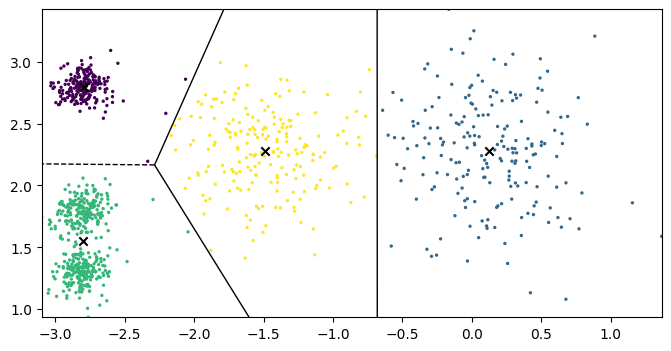

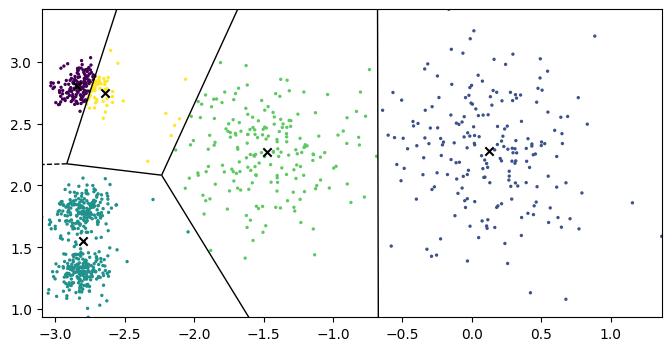

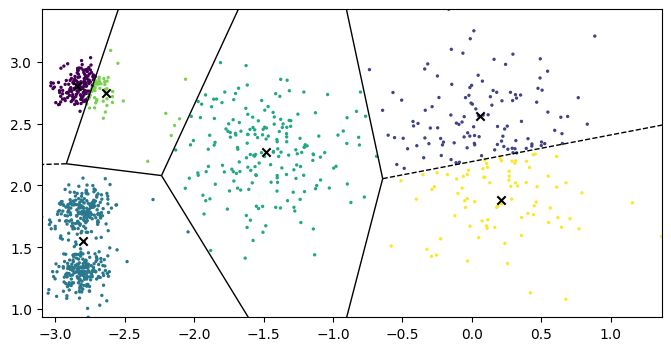

In [10]:
for k in range(4,7):
    KMeansPlot(KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X), X)

One way to choose the number of clusters is looking for an inflection point in the inertia (mean squared distance to the nearest centroid)

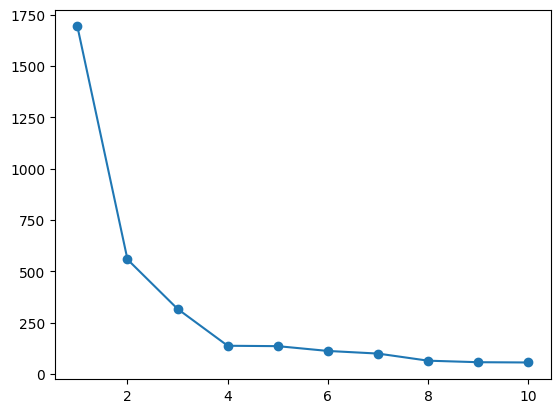

In [11]:
plt.plot(range(1,11), [KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X).inertia_ for k in range(1,11)], '-o');

Another (more expensive) option is to look at the silhouette coefficient $(b-a)/\max(a,b)$, where $a$ is the mean intracluster distance and $b$ is the mean distance to the nearest cluster instances. This score ranges from +1 for a perfect fit (close to all points in the cluster and far from other clusters) to -1 (likely mis-assignment of clusters).

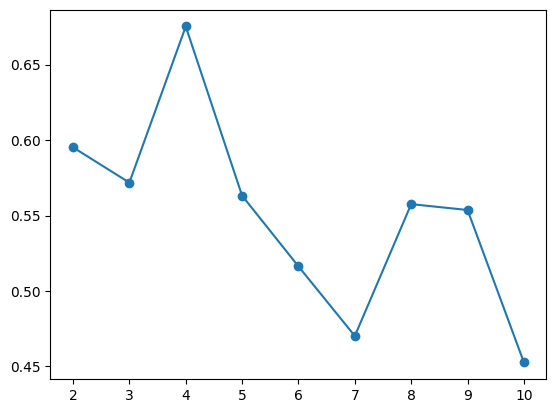

In [12]:
plt.plot(range(2,11), [silhouette_score(X, KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X).labels_) for k in range(2,11)], '-o');

We can use a sillhouette diagram to compare different levels of $k$. For a good choice of $k$, all the clusters should include samples that extend past the dotted line (i.e. each cluster should include samples with sillhouette coefficients that are higher than the average for that value of $k$).

In [13]:
def silhouette_plot(X, labels, ax=None):
    s = silhouette_samples(X, labels)
    order = np.lexsort([s, labels])
    for label in labels:
        ax.fill_betweenx(np.arange(len(s))[labels[order]==label], 0, s[order][labels[order]==label])
    ax.set_xlim((0, 1))
    s_bar = np.mean(s)
    ax.axline((s_bar, 0), (s_bar, 1), dashes=(4,4), color='black')

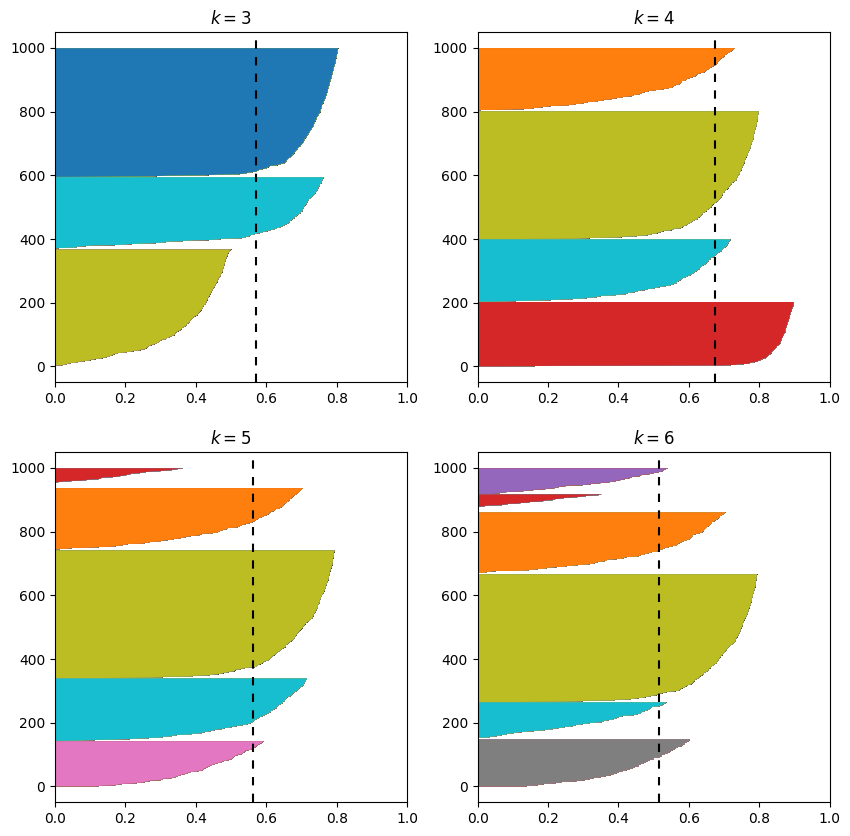

In [14]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

for n_clusters, ax in zip(range(3,7), axs.reshape((-1))):
    labels = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(X).labels_
    silhouette_plot(X, labels, ax=ax)
    ax.set_title(f"$k = {n_clusters}$")

In [15]:
f"{299792458 * 1/201 * 1209600:g}"

'1.80412e+12'

## Clustering for preprocessing

K-means can be used to for preprocessing. Let's try using it on the MNIST dataset.

In [16]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First we develop a baseline model:

In [17]:
m_baseline = LogisticRegression(max_iter=10000, C=0.1)
m_baseline.fit(X_train, y_train)
print(f"Model accuracy: {m_baseline.score(X_test, y_test):.3f} ({m_baseline.score(X_train, y_train):.3f} on training data)")

Model accuracy: 0.973 (1.000 on training data)


Now let's try it again with k-means preprocessing...

In [18]:
m1 = Pipeline([
    ("k_means", KMeans(n_clusters=100, random_state=42, n_init='auto')),
    ("LR", LogisticRegression(max_iter=100000, C=0.1, random_state=42))
])

m1.fit(X_train, y_train)
print(f"Model accuracy: {m1.score(X_test, y_test):.3f} ({m1.score(X_train, y_train):.3f} on training data)")

Model accuracy: 0.976 (0.999 on training data)


In [19]:
m2 = GridSearchCV(m1, {'k_means__n_clusters':[75, 100, 125], 'LR__C':[0.2, 0.1, 0.05]}, cv=3, verbose=2, n_jobs=-1)
m2.fit(X_train, y_train)
print(f"Model accuracy: {m2.score(X_test, y_test):.3f} ({m2.score(X_train, y_train):.3f} on training data)")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Model accuracy: 0.973 (0.999 on training data)


In [20]:
m2.best_params_

{'LR__C': 0.05, 'k_means__n_clusters': 125}

## Clustering for semi-supervised learning

Clustering can also be used for semi-supervised learning. Training on a random small labled subset of the data is not very successful:

In [21]:
n_labeled = 50
m = LogisticRegression(max_iter=100000, C=1, random_state=42)
m.fit(X_train[:n_labeled], y_train[:n_labeled])
print(f"Model accuracy: {m.score(X_test, y_test):.3f} ({m.score(X_train[:n_labeled], y_train[:n_labeled]):.3f} on training data)")

Model accuracy: 0.822 (1.000 on training data)


We can improve this by choosing representative images using k-means and then labeling those instead of random samples:

In [22]:
X_train_clustered = KMeans(n_clusters=n_labeled, random_state=42, n_init='auto').fit_transform(X_train)
exemplar_idx = np.argmin(X_train_clustered, axis=0)

In [23]:
m = LogisticRegression(max_iter=100000, C=1, random_state=42)
m.fit(X_train[exemplar_idx], y_train[exemplar_idx])
print(f"Model accuracy: {m.score(X_test, y_test):.3f} ({m.score(X_train[:n_labeled], y_train[:n_labeled]):.3f} on training data)")

Model accuracy: 0.918 (0.880 on training data)


We can also augment the data set by assuming all of the labels in the cluster match the labeled instance (known as label propogation).

In [24]:
y_train_clusters_ids = np.argmin(X_train_clustered, axis=1)
y_train_propagated = y_train[exemplar_idx][y_train_clusters_ids]

In [25]:
m = LogisticRegression(max_iter=100000, C=1, random_state=42)
m.fit(X_train, y_train_propagated)
print(f"Model accuracy: {m.score(X_test, y_test):.3f} ({m.score(X_train[:n_labeled], y_train[:n_labeled]):.3f} on training data)")

Model accuracy: 0.887 (0.880 on training data)


Note, however, that we have propgated many labels to other digits:

In [26]:
print(f"Label accuracy: {np.sum(y_train_propagated == y_train)/y_train.shape[0] :.3f}")

Label accuracy: 0.933


We can improve this by limiting our propagation to only the points that are closest to their exemplars:

In [27]:
y_train_cluster_distance = np.take_along_axis(X_train_clustered, y_train_clusters_ids.reshape(-1,1), axis=1).reshape(-1)
n_propogated_examplars = int( 0.5 * y_train.shape[0])
propogated_examplar_ids = np.argsort(y_train_cluster_distance)[:n_propogated_examplars]

In [28]:
print(f"Label accuracy: {np.sum(y_train_propagated[propogated_examplar_ids] == y_train[propogated_examplar_ids])/propogated_examplar_ids.shape[0] :.3f}")

Label accuracy: 0.991


In [29]:
m = LogisticRegression(max_iter=100000, C=1, random_state=42)
m.fit(X_train[propogated_examplar_ids], y_train_propagated[propogated_examplar_ids])
print(f"Model accuracy: {m.score(X_test, y_test):.3f} ({m.score(X_train[:n_labeled], y_train[:n_labeled]):.3f} on training data)")

Model accuracy: 0.920 (0.920 on training data)


## DBSCAN clustering

An alternative approach is based on grouping overlapping neighborhoods with sufficient density into clusters (leaving points in the lower-density regions as anomolies). To explore this method, we'll use a 2-moons dataset:

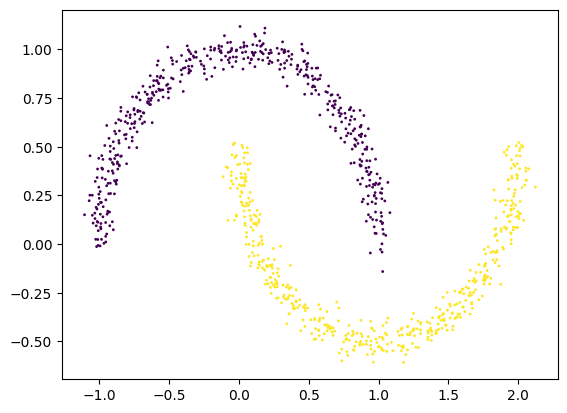

In [30]:
X,y = make_moons(n_samples=2000, noise=0.05, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=1);

Not surprisingly, $k$-means struggles with this dataset:

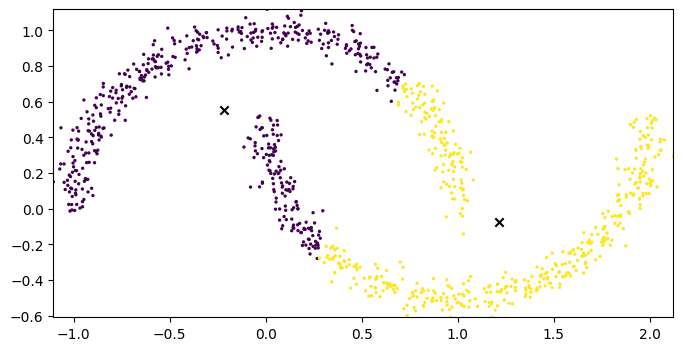

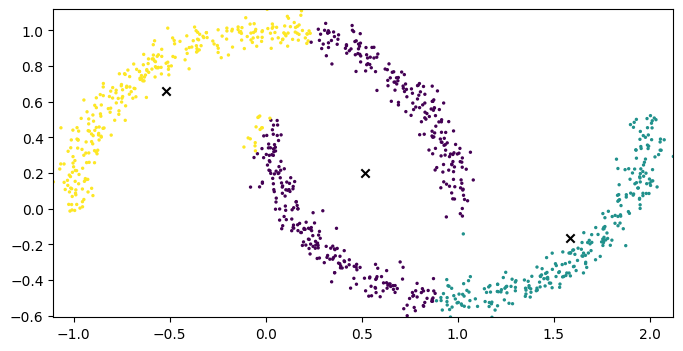

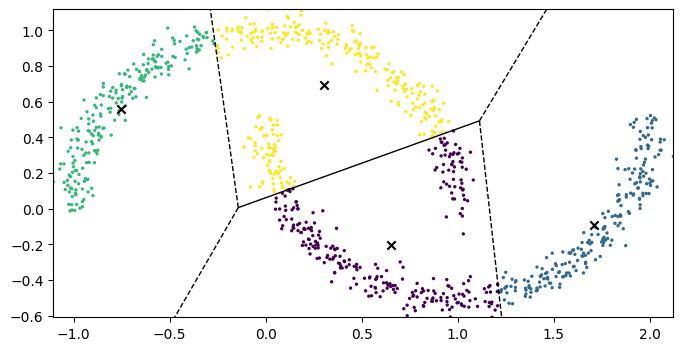

In [31]:
for k in range(2,5):
    KMeansPlot(KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_train), X_train)

DBSCAN does a bit better with an appropriate choice of epsilon:

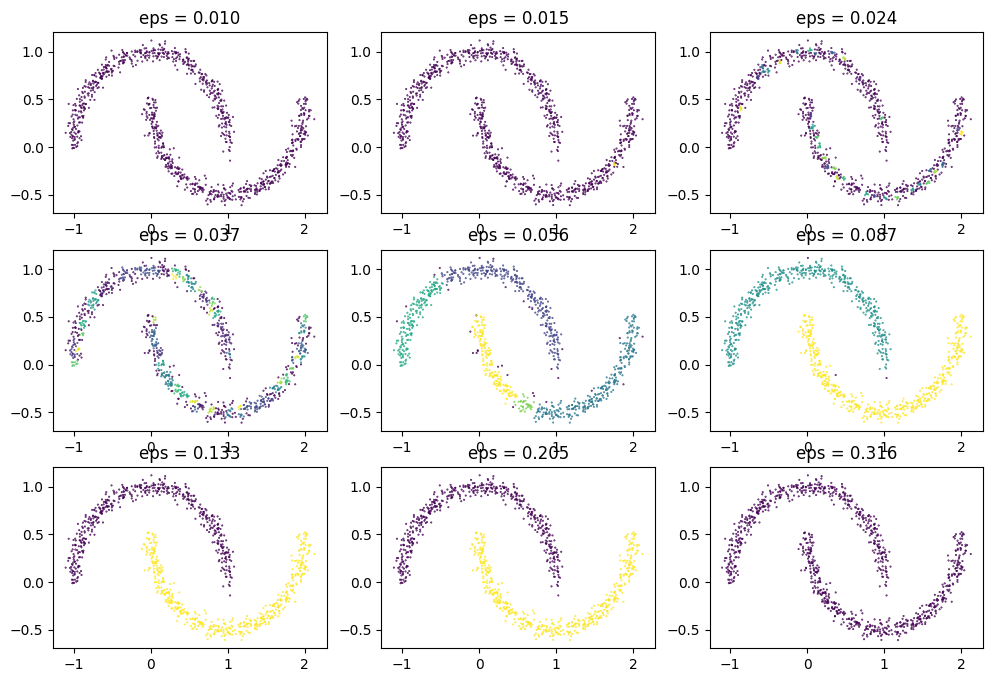

In [32]:
fig, axs = plt.subplots(3,3, figsize=(12,8))
for eps, ax in zip(np.logspace(-2,-0.5,9), axs.flatten()):
    m = DBSCAN(eps=eps)
    y_hat = m.fit_predict(X_train)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_hat, s=0.2);
    ax.set_title(f"eps = {eps:.3f}")

As usual, metrics like the Davies-Bouldin score can help guide the choice a parameters such as epsilon.

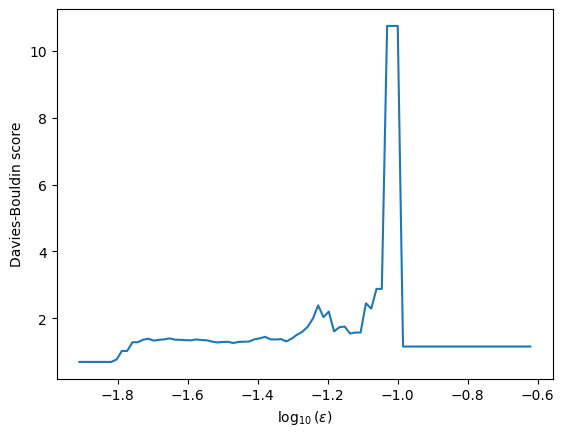

In [33]:
epss = np.logspace(-2,-0.5,100)
def safe_davies_bouldin_score(X, y):
    if len(np.unique(y)) < 2:
        return np.nan
    else:
        return davies_bouldin_score(X, y)
    
scores = [safe_davies_bouldin_score(X_train, DBSCAN(eps=eps).fit_predict(X_train)) for eps in epss]
plt.plot(np.log10(epss), scores, '-');
plt.ylabel("Davies-Bouldin score")
plt.xlabel("$\log_{10}(\epsilon)$");

Note that for this example, this metric prefers solutions with a single outlier over those with two well defined clusters:

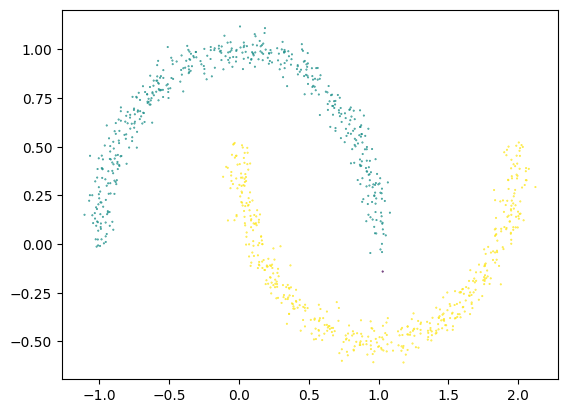

In [34]:
y_hat_train = DBSCAN(eps=epss[np.nanargmax(scores)]).fit_predict(X_train)
plt.scatter(X_train[:,0], X_train[:,1], c=y_hat_train, s=0.2);

The scikit-learn version of DBSCAN does not implement a predict method, so we are forced to do so ourselves using a tool such as k-nearest neighbors.

Model normalized mutual information: 1.00


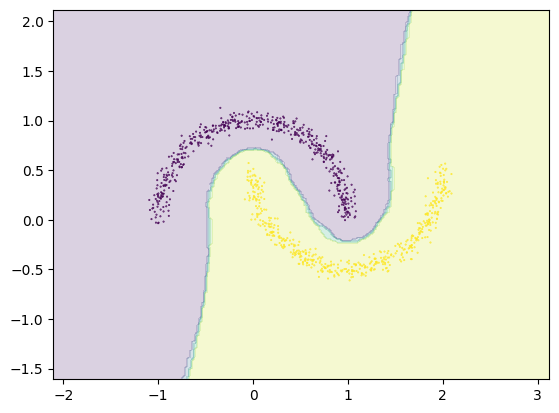

In [35]:
m = KNeighborsClassifier(n_neighbors=3)
m.fit(X_train[y_hat_train != -1], y_hat_train[y_hat_train != -1])
y_hat_test = m.predict(X_test)
print(f"Model normalized mutual information: {normalized_mutual_info_score(y_test, y_hat_test):.2f}")
DecisionBoundaryDisplay.from_estimator(m, X_train, grid_resolution=200, alpha=0.2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=0.2);

## Gaussian mixture models

In [36]:
rng = np.random.default_rng(seed=42)

X_clusters = [
    (200, (-2.8, 2.8), [[0.07,0.05],[0.05,0.07]]),
    (200, (-2.8, 1.8), [[0.05,0.04],[0.04,0.05]]),
    (200, (-2.8, 1.3), [[0.1,-0.08],[-0.08,0.1]]),
    (200, (-1.5, 2.3), [[0.2,0.1],[0.1,0.2]]),
    (200, (0.2, 2.3), [[0.4,-0.1],[-0.1,0.4]]),
    ]

X = np.vstack([
    rng.multivariate_normal(center, scale, size=count)
    for count, center, scale in X_clusters
])
y = np.hstack([
    np.ones(dtype=int, shape=count) * i 
    for i, (count, center, scale) in enumerate(X_clusters)
])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

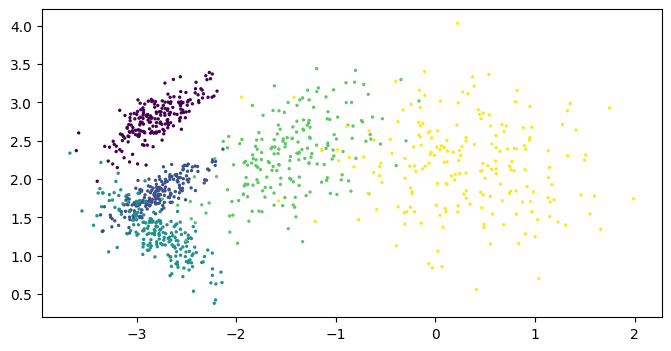

In [37]:
plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], s=2, c=y);

Model normalized mutual information: 0.85


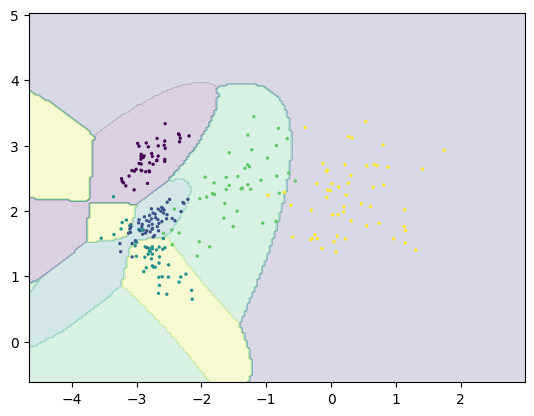

In [38]:
m = GaussianMixture(n_components=5, n_init=20, random_state=42)
m.fit(X_train)
y_hat_test = m.predict(X_test)
print(f"Model normalized mutual information: {normalized_mutual_info_score(y_test, y_hat_test):.2f}")
DecisionBoundaryDisplay.from_estimator(m, X_train, grid_resolution=200, alpha=0.2, response_method="predict")
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=2);

In [39]:
gridshape = (500,500)
X_grid = np.moveaxis(np.meshgrid(np.linspace(-5,3,gridshape[0]), np.linspace(-1,5,gridshape[1])), 0, -1)

In [40]:
proba_grid = m.predict_proba(X_grid.reshape(-1,2)).reshape(gridshape + (-1,))
density_grid = m.score_samples(X_grid.reshape(-1,2)).reshape(gridshape + (-1,))

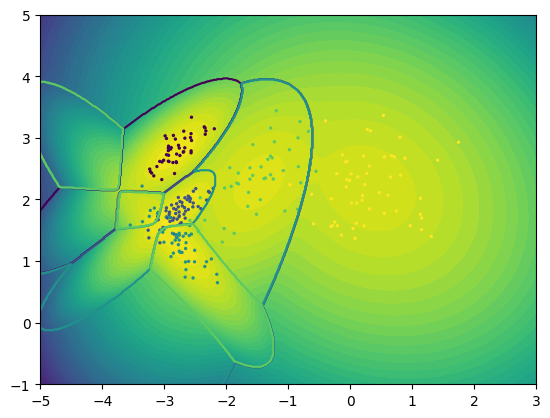

In [41]:
plt.contourf(X_grid[...,0], X_grid[...,1], np.max(density_grid, axis=2), levels=np.linspace(-50,1,50))
plt.contour(X_grid[...,0], X_grid[...,1], np.argmax(proba_grid, axis=2), levels=range(5))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=2);

While we could use tools such as the Sillhouette or Davies-Bouldin scores to choose how many clusters to use, these do not perform well when the clusters have different covanriances. Instead, because we have a likelihood function we can use more powerful tools such as the Aikuke Information Criteria or the Baysean Information Criteria:

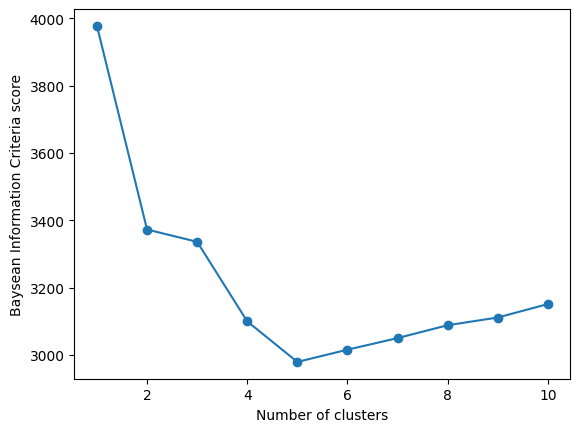

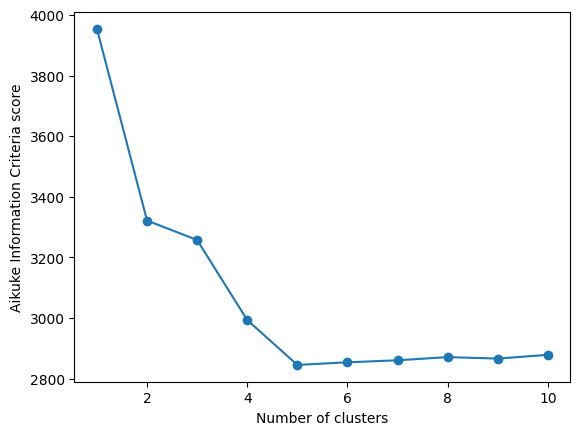

In [42]:
ks = np.arange(1,11)
ms = Parallel(n_jobs=-1)([delayed(lambda k: GaussianMixture(n_components=k, n_init=20, random_state=42).fit(X_train))(k) for k in ks])
aics = Parallel(n_jobs=-1)([delayed(lambda m: m.aic(X_train))(m) for m in ms])
bics = Parallel(n_jobs=-1)([delayed(lambda m: m.bic(X_train))(m) for m in ms])

plt.plot(ks, bics, 'o-');
plt.ylabel("Baysean Information Criteria score")
plt.xlabel("Number of clusters");

plt.figure()
plt.plot(ks, aics, 'o-');
plt.ylabel("Aikuke Information Criteria score")
plt.xlabel("Number of clusters");

We can see that these scores have correctly identified 5 clusters as the best choice for this dataset.

### Bayesean Gaussian Mixture Models

Another option is to take a Bayesean approach and treat the number of clusters and various model parameters as latent variables (and thus find a posterior probability distribution for each of them rather than a single value).

Model normalized mutual information: 0.83
Model cluster weights: 0.179, 0.189, 0.207, 0.203, 0.222, 0.0, 0.0, 0.0, 0.0, 0.0


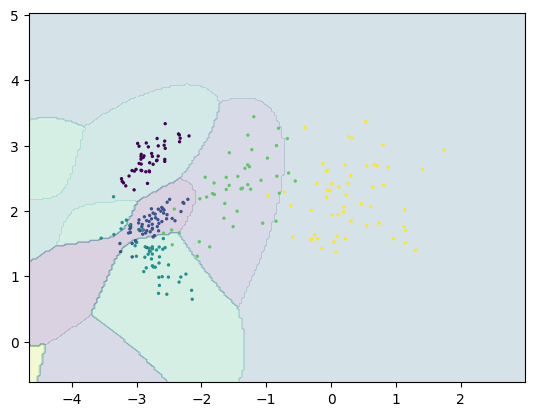

In [43]:
m = BayesianGaussianMixture(n_components=10, n_init=20, random_state=42)
m.fit(X_train)
y_hat_test = m.predict(X_test)
print(f"Model normalized mutual information: {normalized_mutual_info_score(y_test, y_hat_test):.2f}")
print(f"Model cluster weights: {', '.join([str(np.round(weight, 3)) for weight in m.weights_])}")
DecisionBoundaryDisplay.from_estimator(m, X_train, grid_resolution=200, alpha=0.2, response_method="predict")
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=2);

We can see that it identifies 5 clusters as being likely contributors to the distribution.

## Exercises

### 9.1
Clustering attempts to fit a model to the data using an model parameter $N \in \mathbb{Z}^{+}$ (conceptually the number of clusters) and a hidden per-instance value $k \in \mathbb{Z}^{+}$, with $k < N$ (conceptually the cluster assignments). Common clustering approaches discussed in this chapter include $k$-means, DBSCAN, and Gaussian mixture models.

### 9.2

Common uses of clustering models include identifying possible groups for further analysis (e.g. spikes that may come from a single neuron, customers who may have common interests, etc), dimensional reduction, label propagation for semi-supervised learning, and anomaly detection.

### 9.3

Two possible options for choosing the number of clusters are comparing sillhouette plots with different numbers of clusters and looking for an inflection point in the decrease in inertia as the number of clusters increase.

### 9.4

Label propagation is a technique used in semi-supervised learning to propagate labels from labeled examples to similar unlabled examples. It allows an algorithm to use (usually more plentiful) unlabled datapoints to learn the common variation of inputs expected with given labels. On approach is to use a method such as $k$-means to identify clusters of similar inputs, then propagate the label from a labled member of the cluster to all other members of the cluster.

### 9.5

Aglomerative clustering and BIRCH both scale well to large datasets. DBSCAN and Mean-Shift both identify regions of high density.